In [378]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import genfromtxt

## Load Data + Preprocessing

In [379]:
df = pd.read_csv(
    "\\healthcare-dataset-stroke-data.csv"
                )

In [380]:
df.shape

(5110, 12)

In [381]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

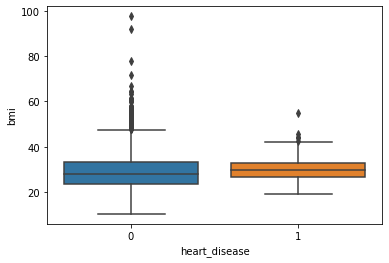

In [382]:
sns.boxplot(data=df,
            x=df['heart_disease'],
            y=df['bmi'])

In [383]:
df.loc[(df['bmi'].isnull())&(df['heart_disease']==0), 'bmi'] = df.loc[df['heart_disease']==0, 'bmi'].mean()

df.loc[(df['bmi'].isnull())&(df['heart_disease']==1), 'bmi'] = df.loc[df['heart_disease']==1, 'bmi'].mean()

In [384]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [385]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [386]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=df['stroke'])

In [387]:
from sklearn.preprocessing import LabelEncoder

for column in X_train: 
    if X_train[column].dtype == np.object_:
        le = LabelEncoder()
        X_train[column] = le.fit_transform(X_train[column])
        X_test[column] = le.transform(X_test[column])

In [388]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(k_neighbors=10,
                   random_state=40)

X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [389]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_os = scaler.fit_transform(X_train_os)
X_test = scaler.transform(X_test)

## Train ML Models Individually

In [390]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

svm_clf = SVC(random_state=40)
svm_clf.fit(X_train_os, y_train_os)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_os, y_train_os)
naive_clf = GaussianNB()
naive_clf.fit(X_train_os, y_train_os)
rf_clf = RandomForestClassifier(random_state=40)
rf_clf.fit(X_train_os, y_train_os)

RandomForestClassifier(random_state=40)

## Train LCA Model

In [391]:
from deslib.dcs.lca import LCA

lca_model = LCA(pool_classifiers=[svm_clf, knn_clf, naive_clf, rf_clf],
                random_state=40)

In [392]:
lca_model.fit(X_train_os, y_train_os)

LCA(k=2,
    pool_classifiers=[SVC(random_state=40), KNeighborsClassifier(),
                      GaussianNB(), RandomForestClassifier(random_state=40)],
    random_state=40)

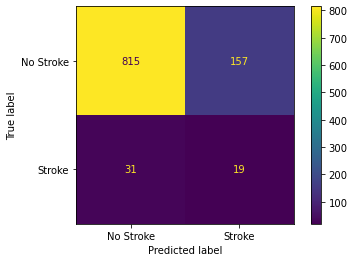

              precision    recall  f1-score   support

   No Stroke       0.96      0.84      0.90       972
      Stroke       0.11      0.38      0.17        50

    accuracy                           0.82      1022
   macro avg       0.54      0.61      0.53      1022
weighted avg       0.92      0.82      0.86      1022



In [393]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = lca_model.predict(X_test)

# creating and plotting the confusion matrix
lca_confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(lca_confusion_matrix, display_labels=['No Stroke', 'Stroke'])
disp.plot()
plt.show()

# creating classification report
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))

## Gridsearch for Hyperparameter Tuning

In [405]:
from sklearn.metrics import f1_score

param_grid = { 
    'k' : list(range(2, 53, 5)),
    'dfp' : [True, False],
    'with_IH' : [True, False]
    }
results = {
    'k': [],
    'dfp': [],
    'with_IH': [],
    'f1_score': []
    }
i = 0
for k in param_grid['k']:
    for dfp in param_grid['dfp']:
        for with_IH in param_grid['with_IH']:
            
            lca_model = LCA(pool_classifiers=[svm_clf, knn_clf, naive_clf, rf_clf],
                            k=k,
                            DFP=dfp,
                            with_IH=with_IH,
                            random_state=40)

            lca_model.fit(X_train_os, y_train_os)
            
            y_pred = lca_model.predict(X_test)
            
            results['k'].append(k)
            results['dfp'].append(dfp)
            results['with_IH'].append(with_IH)
            results['f1_score'].append(f1_score(y_test, y_pred))
            
            i += 1
            print(i)          

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [406]:
max_index = results['f1_score'].index(max(results['f1_score']))
best_k = results['k'][max_index]
best_dfp = results['dfp'][max_index]
best_with = results['with_IH'][max_index]

In [407]:
lca_model = LCA(pool_classifiers=[svm_clf, knn_clf, naive_clf, rf_clf],
                            k=best_k,
                            DFP=best_dfp,
                            with_IH=best_with,
                            random_state=40)
lca_model.fit(X_train_os, y_train_os)

LCA(DFP=True, k=2,
    pool_classifiers=[SVC(random_state=40), KNeighborsClassifier(),
                      GaussianNB(), RandomForestClassifier(random_state=40)],
    random_state=40, safe_k=2, with_IH=True)

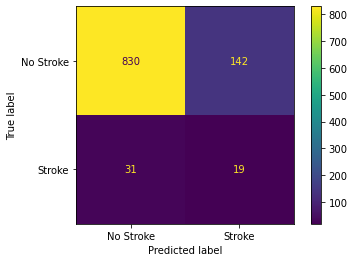

              precision    recall  f1-score   support

   No Stroke       0.96      0.85      0.91       972
      Stroke       0.12      0.38      0.18        50

    accuracy                           0.83      1022
   macro avg       0.54      0.62      0.54      1022
weighted avg       0.92      0.83      0.87      1022



In [408]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = lca_model.predict(X_test)

# creating and plotting the confusion matrix
lca_confusion_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(lca_confusion_matrix, display_labels=['No Stroke', 'Stroke'])
disp.plot()
plt.show()

# creating classification report
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))